### Library

In [1]:
#Import Library
import pandas as pd
import random as r
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")
import time, warnings
import datetime as dt
from pandas.plotting import scatter_matrix
%matplotlib inline

### Data Prepocessing

#### 1. Data Customer

In [2]:
#Reading the raw data
data1 = pd.read_csv("Customer.csv")

In [3]:
#visual control of the first five rows
data1.head()

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [4]:
data1.shape

(5647, 4)

In [5]:
ph_no = []

In [6]:
# the first number should be in the range of 6 to 9
ph_no.append(r.randint(6, 9))

In [7]:
# the for loop is used to append the other 9 numbers.
# the other 9 numbers can be in the range of 0 to 9.
for i in range(1, 10):
    ph_no.append(r.randint(0, 9))
  
# printing the number
for i in ph_no:
    print(i, end="")

8086822445

In [8]:
import copy
data = copy.deepcopy(data1)

In [9]:
#Cek Missing Value
data = data.drop(data.columns[0],axis=1)
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("Columns data types:\n{}".format(data.dtypes))

Database has 5647 obserwations (customers) and 3 columns (attributes).
Missing values in each column:
DOB          0
Gender       2
city_code    2
dtype: int64
Columns data types:
DOB           object
Gender        object
city_code    float64
dtype: object


In [10]:
data["Gender"].fillna("No Gender", inplace = True)
data["city_code"].fillna(0, inplace = True)

data

,DOB,Gender,city_code
0,02-01-1970,M,4.0
1,07-01-1970,F,8.0
2,08-01-1970,F,8.0
3,10-01-1970,F,2.0
4,11-01-1970,M,1.0
...,...,...,...
5642,19-12-1992,M,2.0
5643,24-12-1992,M,6.0
5644,25-12-1992,F,3.0
5645,27-12-1992,F,5.0


In [85]:
data1.head()

,customer_Id,DOB,Gender,city_code,clusters_predict,age
0,268408,02-01-1970,M,4.0,0,51.0
1,269696,07-01-1970,F,8.0,1,50.0
2,268159,08-01-1970,F,8.0,1,50.0
3,270181,10-01-1970,F,2.0,1,50.0
4,268073,11-01-1970,M,1.0,0,50.0


In [11]:
data.city_code.unique()

array([ 4.,  8.,  2.,  1.,  5.,  9.,  7., 10.,  6.,  3.,  0.])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DOB        5647 non-null   object 
 1   Gender     5647 non-null   object 
 2   city_code  5647 non-null   float64
dtypes: float64(1), object(2)
memory usage: 132.5+ KB


In [13]:
#Possible (unique) values in each categorical column
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
DOB          4056
Gender          3
city_code      11
dtype: int64


In [14]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
DOB : ['02-01-1970' '07-01-1970' '08-01-1970' ... '25-12-1992' '27-12-1992'
 '29-12-1992']
Gender : ['M' 'F' 'No Gender']


In [15]:
#Extract age from date of birth
now = pd.Timestamp('now')
data['DOB'] = pd.to_datetime(data['DOB'])    # 1
data['DOB'] = data['DOB'].where(data['DOB'] < now, data['DOB'] -  np.timedelta64(100, 'Y'))   # 2
data['age'] = (now - data['DOB']).astype('<m8[Y]')    # 3
data.head()

,DOB,Gender,city_code,age
0,1970-02-01,M,4.0,51.0
1,1970-07-01,F,8.0,50.0
2,1970-08-01,F,8.0,50.0
3,1970-10-01,F,2.0,50.0
4,1970-11-01,M,1.0,50.0


In [16]:
data.age.value_counts()

33.0    273
31.0    266
41.0    259
32.0    255
45.0    254
49.0    254
42.0    253
35.0    252
46.0    251
40.0    250
39.0    245
43.0    244
38.0    242
36.0    240
29.0    237
47.0    235
44.0    234
34.0    233
48.0    232
37.0    229
30.0    229
50.0    224
28.0    181
51.0     75
Name: age, dtype: int64

#### Product Info

In [17]:
df_prod_info = pd.read_csv('prod_cat_info.csv')
df_prod_info.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [18]:
df_trans = pd.read_csv('df_trans_new.csv')
df_trans = df_trans.rename(columns={'prod_subcat_code':'prod_sub_cat_code'})
df_trans.head()

,transaction_id,cust_id,tran_date,prod_sub_cat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,prod_cat_x,prod_cat_y,prod_cat_x.1,prod_cat_y.1,prod_cat
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Clothing,Clothing,Clothing,Clothing
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,Electronics,Electronics,Electronics,Electronics
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,Books,Books,Books,Books
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,Home and kitchen,Home and kitchen,Home and kitchen,Home and kitchen,Home and kitchen
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,Books,Books,Books,Books


In [19]:
df_trans.shape

(23053, 15)

In [20]:
df_trans = df_trans.merge(df_prod_info[['prod_cat_code','prod_cat']].drop_duplicates(), on='prod_cat_code', how='left')
df_trans.head()

,transaction_id,cust_id,tran_date,prod_sub_cat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,prod_cat_x,prod_cat_y,prod_cat_x.1,prod_cat_y.1,prod_cat_x,prod_cat_y
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Clothing,Clothing,Clothing,Clothing,Clothing
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,Electronics,Electronics,Electronics,Electronics,Electronics
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,Books,Books,Books,Books,Books
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,Home and kitchen,Home and kitchen,Home and kitchen,Home and kitchen,Home and kitchen,Home and kitchen
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,Books,Books,Books,Books,Books


In [21]:
df_trans.shape

(23053, 16)

In [22]:
df_prod_info.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [23]:
df_trans.to_csv('df_trans_new.csv', index=False)

#### 3. Eksplorasi data

<AxesSubplot:>

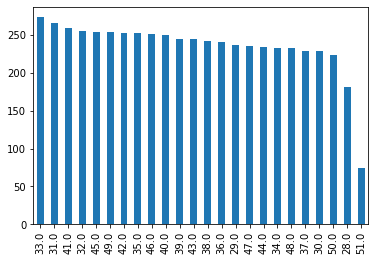

In [24]:
#Bar Plot "AGE"
data['age'].value_counts().plot(kind='bar')

<AxesSubplot:>

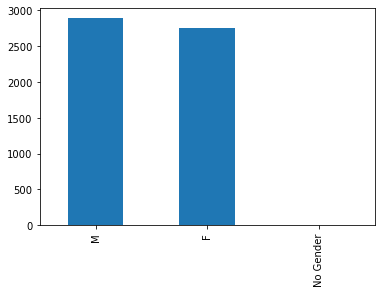

In [25]:
#Bar Plot Gender
data['Gender'].value_counts().plot(kind='bar')

In [26]:
data.Gender.value_counts()

M            2892
F            2753
No Gender       2
Name: Gender, dtype: int64

<AxesSubplot:>

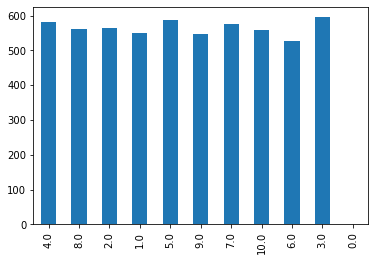

In [27]:
data['city_code'].value_counts(sort=False).plot.bar()

In [28]:
data.city_code.value_counts()

3.0     595
5.0     586
4.0     582
7.0     575
2.0     564
8.0     562
10.0    558
1.0     551
9.0     546
6.0     526
0.0       2
Name: city_code, dtype: int64

In [29]:
data.columns


Index(['DOB', 'Gender', 'city_code', 'age'], dtype='object')

### Cluster with K-Means

In [30]:
data.head()

,DOB,Gender,city_code,age
0,1970-02-01,M,4.0,51.0
1,1970-07-01,F,8.0,50.0
2,1970-08-01,F,8.0,50.0
3,1970-10-01,F,2.0,50.0
4,1970-11-01,M,1.0,50.0


In [31]:
data.DOB.nunique()

4056

In [32]:
#Selecting columns for clusterisation with k-means
selected_columns = ["age","city_code","Gender"]
cluster_data = data.loc[:,selected_columns]

In [33]:
def distributions(df):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
    sns.distplot(df["age"], ax=ax1)
    sns.distplot(df["city_code"], ax=ax2)
    plt.tight_layout()

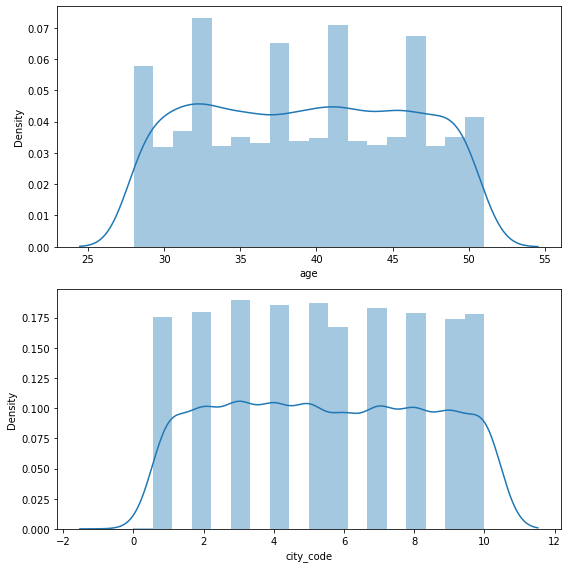

In [34]:
distributions(cluster_data)

In [35]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(pd.get_dummies(cluster_data))

In [36]:
cluster_data.isnull().sum()

age          0
city_code    0
Gender       0
dtype: int64

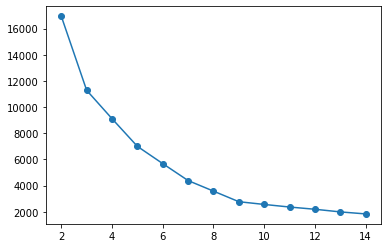

In [37]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

In [38]:
import time
startTime = time.time()

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(cluster_scaled)
data1['clusters_predict'] = kmeans.predict(cluster_scaled)


print('\nruntime :'+str(time.time()-startTime)+'\n' )
data1.head()


runtime :1.1208372116088867



,customer_Id,DOB,Gender,city_code,clusters_predict
0,268408,02-01-1970,M,4.0,0
1,269696,07-01-1970,F,8.0,1
2,268159,08-01-1970,F,8.0,1
3,270181,10-01-1970,F,2.0,1
4,268073,11-01-1970,M,1.0,0


In [39]:
data.shape

(5647, 4)

In [40]:
data1.shape

(5647, 5)

In [41]:
data1['age'] = data['age']
data1.head()

,customer_Id,DOB,Gender,city_code,clusters_predict,age
0,268408,02-01-1970,M,4.0,0,51.0
1,269696,07-01-1970,F,8.0,1,50.0
2,268159,08-01-1970,F,8.0,1,50.0
3,270181,10-01-1970,F,2.0,1,50.0
4,268073,11-01-1970,M,1.0,0,50.0


In [42]:
data1.shape

(5647, 6)

In [43]:
data1.to_csv('customer_new.csv', index=False)

### Get the Data

In [44]:
data.shape

(5647, 4)

In [45]:
data2 = pd.read_csv("Transactions.csv")

In [46]:
data2.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [47]:
#check the shape
transactions_type = data2[data2['Store_type']=='e-Shop']

transactions_type.shape

(9311, 10)

In [48]:
#last date available in our dataset
transactions_type['transaction_id'].max()

99987549630

In [49]:
#remove canceled orders
transactions_type = transactions_type[transactions_type['Qty']>0]
transactions_type.shape

(8429, 10)

In [50]:
#remove rows where customerID are NA
transactions_type.dropna(subset=['cust_id'],how='all',inplace=True)
transactions_type.shape

(8429, 10)

In [51]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
transactions_type = transactions_type[transactions_type['tran_date']>= "2014-12-31"]
transactions_type.shape

(4902, 10)

In [52]:
#exploring the unique values of each attribute

print("Summary..")

print("Number of transactions: ", transactions_type['tran_date'].nunique())
print("Number of products bought: ",transactions_type['prod_cat_code'].nunique())
print("Number of customers:",transactions_type['cust_id'].nunique() )
print("Percentage of customers NA: ", round(transactions_type['cust_id'].isnull().sum() * 100 / len(data2),2),"%" )

Summary..
Number of transactions:  642
Number of products bought:  6
Number of customers: 3265
Percentage of customers NA:  0.0 %


###    RFM Analysis

#### Recency

In [53]:
#To calculate recency, 
#we need to choose a date point from which we evaluate how many days ago was the customer's last purchase

#last date available in our dataset
transactions_type['tran_date'].max()

'9/9/2013'

In [54]:
#create a new column called date which contains the date of transactions only
transactions_type['date'] = pd.DatetimeIndex(transactions_type['tran_date']).date
transactions_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4902 entries, 201 to 23049
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    4902 non-null   int64  
 1   cust_id           4902 non-null   int64  
 2   tran_date         4902 non-null   object 
 3   prod_subcat_code  4902 non-null   int64  
 4   prod_cat_code     4902 non-null   int64  
 5   Qty               4902 non-null   int64  
 6   Rate              4902 non-null   int64  
 7   Tax               4902 non-null   float64
 8   total_amt         4902 non-null   float64
 9   Store_type        4902 non-null   object 
 10  date              4902 non-null   object 
dtypes: float64(2), int64(6), object(3)
memory usage: 459.6+ KB


In [55]:
#group by customers and check last date of purshace
recency_df = transactions_type.groupby(by='cust_id', as_index=False)['date'].max()
recency_df.columns = ['cust_id','LastPurshaceDate']
recency_df.head()

,cust_id,LastPurshaceDate
0,266783,2013-09-02
1,266784,2012-09-09
2,266785,2011-10-24
3,266794,2013-06-29
4,266799,2013-09-24


In [56]:
recency_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cust_id           3265 non-null   int64 
 1   LastPurshaceDate  3265 non-null   object
dtypes: int64(1), object(1)
memory usage: 76.5+ KB


In [57]:
recency_df.head()

,cust_id,LastPurshaceDate
0,266783,2013-09-02
1,266784,2012-09-09
2,266785,2011-10-24
3,266794,2013-06-29
4,266799,2013-09-24


In [58]:
#calculate recency
recency_df['LastPurshaceDate'] = pd.to_datetime(recency_df['LastPurshaceDate'])
recency_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cust_id           3265 non-null   int64         
 1   LastPurshaceDate  3265 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 76.5 KB


In [59]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [60]:
recency_df.head()

,cust_id,LastPurshaceDate,Recency
0,266783,2013-09-02,2780
1,266784,2012-09-09,3138
2,266785,2011-10-24,3459
3,266794,2013-06-29,2845
4,266799,2013-09-24,2758


In [61]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

### Frequency

In [62]:
# drop duplicates
transactions_type_copy = transactions_type
transactions_type_copy.drop_duplicates(subset=['tran_date', 'cust_id'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = transactions_type_copy.groupby(by=['cust_id'], as_index=False)['tran_date'].count()
frequency_df.columns = ['cust_id','Frequency']
frequency_df.head()

,cust_id,Frequency
0,266783,2
1,266784,1
2,266785,1
3,266794,3
4,266799,1


### Monetary

In [63]:
#create column total cost
transactions_type['TotalCost'] = transactions_type['Qty'] *transactions_type['total_amt']

In [64]:
monetary_df = transactions_type.groupby(by='cust_id',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['cust_id','Monetary']
monetary_df.head()

,cust_id,Monetary
0,266783,27045.98
1,266784,4862.00
2,266785,6271.98
3,266794,17578.34
4,266799,897.26


### Create RFM Table

In [65]:
recency_df.head()

,cust_id,Recency
0,266783,2780
1,266784,3138
2,266785,3459
3,266794,2845
4,266799,2758


In [66]:
frequency_df.head()

,cust_id,Frequency
0,266783,2
1,266784,1
2,266785,1
3,266794,3
4,266799,1


In [67]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='cust_id')
temp_df.head()

,cust_id,Recency,Frequency
0,266783,2780,2
1,266784,3138,1
2,266785,3459,1
3,266794,2845,3
4,266799,2758,1


In [68]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='cust_id')
#use CustomerID as index
rfm_df.set_index('cust_id',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
cust_id,,,
266783,2780,2,27045.98
266784,3138,1,4862.00
266785,3459,1,6271.98
266794,2845,3,17578.34
266799,2758,1,897.26


### RFM Table Correctness verification

In [69]:
transactions_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4899 entries, 201 to 23049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    4899 non-null   int64  
 1   cust_id           4899 non-null   int64  
 2   tran_date         4899 non-null   object 
 3   prod_subcat_code  4899 non-null   int64  
 4   prod_cat_code     4899 non-null   int64  
 5   Qty               4899 non-null   int64  
 6   Rate              4899 non-null   int64  
 7   Tax               4899 non-null   float64
 8   total_amt         4899 non-null   float64
 9   Store_type        4899 non-null   object 
 10  date              4899 non-null   object 
 11  TotalCost         4899 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 497.6+ KB


In [70]:
transactions_type[transactions_type['cust_id']==266794]

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,date,TotalCost
4908,42435707527,266794,29-06-2013,10,3,1,123,12.915,135.915,e-Shop,2013-06-29,135.915
12379,25044564554,266794,28-06-2012,3,2,3,1137,358.155,3769.155,e-Shop,2012-06-28,11307.465
15503,89950500283,266794,30-01-2012,3,1,4,347,145.740,1533.740,e-Shop,2012-01-30,6134.960


### RFM Quartiles

In [71]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,2821.0,1.0,3435.445
0.50,3063.0,1.0,10469.875
0.75,3333.0,2.0,22371.830


In [72]:
quantiles.to_dict()

{'Recency': {0.25: 2821.0, 0.5: 3063.0, 0.75: 3333.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 3435.4449999999997,
  0.5: 10469.875,
  0.75: 22371.829999999998}}

### Creation of RFM Segments

In [73]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [74]:
rfm_df.head()

,Recency,Frequency,Monetary
cust_id,,,
266783,2780,2,27045.98
266784,3138,1,4862.00
266785,3459,1,6271.98
266794,2845,3,17578.34
266799,2758,1,897.26


In [75]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [76]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
cust_id,,,,,,
266783,2780,2,27045.98,4,3,4
266784,3138,1,4862.00,2,1,2
266785,3459,1,6271.98,1,1,2
266794,2845,3,17578.34,3,4,3
266799,2758,1,897.26,4,1,1


In [77]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
cust_id,,,,,,,
266783,2780,2,27045.98,4,3,4,434
266784,3138,1,4862.00,2,1,2,212
266785,3459,1,6271.98,1,1,2,112
266794,2845,3,17578.34,3,4,3,343
266799,2758,1,897.26,4,1,1,411


In [78]:
#Best Recency score = 4: most recently purchase
#Best Frequency score = 4: most quantity purchase
#Best Monetary score = 4: spent the most

In [79]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
cust_id,,,,,,,
267634,2729,3,95332.770,4,4,4,444
268076,2811,5,79059.435,4,4,4,444
269980,2721,4,78414.115,4,4,4,444
268097,2821,3,76607.440,4,4,4,444
274512,2781,4,71725.550,4,4,4,444
269565,2817,4,71314.490,4,4,4,444
270076,2758,3,69208.360,4,4,4,444
272590,2773,3,65530.920,4,4,4,444
268335,2637,5,63387.220,4,4,4,444


In [80]:
# Calculate RFM_Score
rfm_segmentation['RFM_Score_Sum'] = rfm_segmentation[['R_Quartile','F_Quartile','M_Quartile']].sum(axis=1)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,RFM_Score_Sum
cust_id,,,,,,,,
266783,2780,2,27045.98,4,3,4,434,11
266784,3138,1,4862.00,2,1,2,212,5
266785,3459,1,6271.98,1,1,2,112,4
266794,2845,3,17578.34,3,4,3,343,10
266799,2758,1,897.26,4,1,1,411,6


In [81]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score_Sum'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score_Sum'] >= 8) and (df['RFM_Score_Sum'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score_Sum'] >= 7) and (df['RFM_Score_Sum'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score_Sum'] >= 6) and (df['RFM_Score_Sum'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score_Sum'] >= 5) and (df['RFM_Score_Sum'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score_Sum'] >= 4) and (df['RFM_Score_Sum'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm_segmentation['RFM_Level'] = rfm_segmentation.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,RFM_Score_Sum,RFM_Level
cust_id,,,,,,,,,
266783,2780,2,27045.98,4,3,4,434,11,Can't Loose Them
266784,3138,1,4862.00,2,1,2,212,5,Promising
266785,3459,1,6271.98,1,1,2,112,4,Needs Attention
266794,2845,3,17578.34,3,4,3,343,10,Can't Loose Them
266799,2758,1,897.26,4,1,1,411,6,Potential


In [82]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_segmentation.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them    2844.0       2.4  28251.4   897
Champions           2976.1       1.6  17534.1   371
Loyal               3019.1       1.3  14467.1   366
Needs Attention     3403.9       1.0   3971.3   405
Potential           3094.3       1.1  11264.1   497
Promising           3217.8       1.0   7296.6   479
Require Activation  3556.9       1.0   1358.6   250


From here, we can see that a large percentage (~60%) of our customers are in the top tier RFM levels. The store must be doing something right to be maintaining their loyalty!
The other 40% will need some work. Let’s explore using some ads to re-target them:
Potential — high potential to enter our loyal customer segments, why not throw in some freebies on their next purchase to show that you value them!
Promising — showing promising signs with quantity and value of their purchase but it has been a while since they last bought sometime from you. Let’s target them with their wishlist items and a limited time offer discount.
Needs Attention — made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.
Require Activation — Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

In [83]:
rfm_segmentation.reset_index(inplace=True)
rfm_segmentation.head()

,cust_id,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,RFM_Score_Sum,RFM_Level
0,266783,2780,2,27045.98,4,3,4,434,11,Can't Loose Them
1,266784,3138,1,4862.00,2,1,2,212,5,Promising
2,266785,3459,1,6271.98,1,1,2,112,4,Needs Attention
3,266794,2845,3,17578.34,3,4,3,343,10,Can't Loose Them
4,266799,2758,1,897.26,4,1,1,411,6,Potential


In [84]:
rfm_segmentation.to_csv('rfm_result.csv', index=False)